In [1]:
import numpy as np
from joblib import Parallel, delayed

from symbolic_regression.methods.gp import GP
from symbolic_regression.methods.gpshap import GPSHAP
from symbolic_regression.methods.gpcmi import GPCMI

from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split
from symbolic_regression.datasets import load_datasets


import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 30
test_size = 0.2
val_size = 0.25
n_top_features = None
k = 5
ci = 0.99
record_interval = 5

pysr_params = {
    "populations": 5,
    "population_size": 20,
    "niterations": 50,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0
}

dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
width = max([round(len(name)+10, -1) for name in datasets.keys()])

datasets.keys()

dict_keys(['F1'])

In [3]:
gp_params = {
    "loss_function": nrmse_loss,
    "record_interval": record_interval,
    **pysr_params,
}

gpshap_params = {**gp_params}

gpcmi_params = {
    **gp_params,
    "k": k,
    "ci": ci
}

shap_params = {
    "test_size": test_size,
    "val_size": val_size,
    "n_runs": n_runs,
    "n_top_features": n_top_features,
    **gp_params
}

In [4]:
gp = GP(**gp_params)
gpshap = GPSHAP(**gpshap_params)
gpcmi = GPCMI(**gpcmi_params)

methods = {
    "GP": gp,
    "GPSHAP": gpshap,
    "GPCMI": gpcmi
}

n_records = methods[list(methods.keys())[0]].n_records
n_records

10

In [5]:
print(gpshap._feature_cache)
gpshap._feature_cache = {}

{}


In [ ]:
results = {}
equations = {}
features = {}

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}
    train_val_test_sets = []

    X = dataset["X"]
    y = dataset["y"]

    for _ in range(n_runs):
        train_val_test_set = train_val_test_split(X, y)
        train_val_test_sets.append(train_val_test_set)

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name} on {dataset_name:<{width}}", end="")

        if (method_name == "GPSHAP"):
            if equations[dataset_name].get('GP', False):
                X_trains = tuple([train_val_test_set[0] for train_val_test_set in train_val_test_sets])
                gp_equations = [eqs[-1] for eqs in equations[dataset_name]['GP']]
                method.precompute_features_from_pretrained_models(X_trains, gp_equations)
            
            else: method.precompute_features(X, y, **shap_params)

        for run in range(n_runs):
            print(".", end="")

            temp_losses, temp_best_eqs, temp_features = method.run(
                train_val_test_sets[run]
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_losses[0]
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_losses[1]
            results[dataset_name][method_name]["test_losses"][run, :] = temp_losses[2]
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(temp_features)

        print("Done")

Running GP on F1        ..............................Done
Running GPSHAP on F1         (cached)
Cashed equations found.
Selected features: ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3']
..............................Done
Running GPCMI on F1        ..............................Done


In [ ]:
# NOTE: The following code is for parallel processing of tasks across datasets and methods.

all_tasks = []
for dataset_name, dataset in datasets.items():
    X = dataset["X"]
    y = dataset["y"]
    
    for method_name, method in methods.items():
        for run in range(n_runs):
            all_tasks.append((dataset_name, method_name, run, X, y, method))

# Function για κάθε task
def process_task(task):
    dataset_name, method_name, run, X, y, method = task
    
    train_val_test_set = train_val_test_split(X, y)
    temp_losses, temp_best_eqs, temp_features = method.run(train_val_test_set)
    
    return {
        'dataset_name': dataset_name,
        'method_name': method_name,
        'run': run,
        'losses': temp_losses,
        'equations': temp_best_eqs,
        'features': temp_features
    }

# Παραλληλοποίηση όλων των tasks μαζί
print(f"Processing {len(all_tasks)} tasks on {min(len(all_tasks), 20)} cores...")
task_results: list[dict] = Parallel(n_jobs=-1)(delayed(process_task)(task) for task in all_tasks) # type: ignore

# Οργάνωση των αποτελεσμάτων
results = {}
equations = {}
features = {}

for result in task_results:
    dataset_name = result['dataset_name']
    method_name = result['method_name']
    run = result['run']
    
    # Αρχικοποίηση δομών αν χρειάζεται
    if dataset_name not in results:
        results[dataset_name] = {}
        equations[dataset_name] = {}
        features[dataset_name] = {}
    
    if method_name not in results[dataset_name]:
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []
    
    # Αποθήκευση αποτελεσμάτων
    results[dataset_name][method_name]["training_losses"][run, :] = result['losses'][0]
    results[dataset_name][method_name]["validation_losses"][run, :] = result['losses'][1]
    results[dataset_name][method_name]["test_losses"][run, :] = result['losses'][2]
    equations[dataset_name][method_name].append(result['equations'])
    features[dataset_name][method_name].append(result['features'])

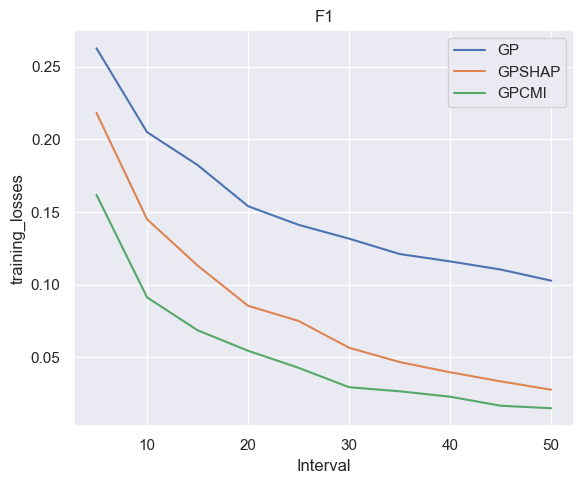

In [7]:
metrics = 'training_losses'
# metrics = 'validation_losses'
# metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [11]:
features['F1']['GPSHAP']

[['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noise_3'],
 ['X1', 'X2', 'X3', 'noise_37', 'noise_27', 'noi